In [ ]:
# импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Предсказание уровней воды на реке Амур

In [ ]:
# Описание  исходных данных в файлах
# https://github.com/sberbank-ai/no_flood_with_ai_aij2020/blob/main/desc/datasets_description_ru.md
# Описание задачи, которую можно решать
# https://github.com/sberbank-ai/no_flood_with_ai_aij2020
# Данные 
# https://storage.yandexcloud.net/datasouls-ods/materials/c8b9bab3/datasets.zip

In [ ]:
%%bash
curl -o datasets.zip "https://storage.yandexcloud.net/datasouls-ods/materials/c8b9bab3/datasets.zip" 
unzip -o -q datasets.zip
rm -f datasets.zip
rm -r __MACOSX

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  303M  100  303M    0     0  18.4M      0  0:00:16  0:00:16 --:--:-- 21.3M


1. Периодические значения (раз в 5 дней) высоты снега и толщины льда на гидропостах Содержат ежедневные значения уровня воды и температуры воды на гидрологический постах за период с 1984 по 2018 гг.

In [ ]:
path_to_hydro = './datasets/hydro/'
files_hydro = ! ls -1 $path_to_hydro

# 1. Ежедневные значения уровня воды и температуры на гидрологический постах за период с 1984 по 2018 гг.

In [ ]:
files_hydro_daily = [f for f in files_hydro if '_daily' in f] 

In [ ]:
%%time
# Собираем в pandas dataframe 
daily = []
for filename in files_hydro_daily:
    tmp = pd.read_csv(path_to_hydro + filename, \
    encoding = 'cp1251', sep = ';', skiprows = 2, index_col = False, \
    names = ['date','stage_avg','stage_min','stage_max','temp','water_code'])
    tmp['id'] = int(filename.replace('_daily.csv', ''))
    daily.append(tmp)
daily = pd.concat(daily)

CPU times: user 4.03 s, sys: 494 ms, total: 4.53 s
Wall time: 4.57 s


In [ ]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2201371 entries, 0 to 5630
Data columns (total 7 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   date        object
 1   stage_avg   object
 2   stage_min   object
 3   stage_max   object
 4   temp        object
 5   water_code  object
 6   id          int64 
dtypes: int64(1), object(6)
memory usage: 134.4+ MB


In [ ]:
# Переиндексируем:
daily.reset_index(drop=True, inplace=True)

In [ ]:
# Очищаем от мусора + приводим к нужным типам

daily['date'] = pd.to_datetime(daily['date'], format='%d.%m.%Y')

daily.loc[daily['stage_avg'] == '       ', 'stage_avg'] = np.nan ## иначе из string нельзя перевести в float
daily['stage_avg'] = daily['stage_avg'].astype('float16')

daily.loc[daily['stage_min'] == '       ', 'stage_min'] = np.nan ## иначе из string нельзя перевести в float
daily['stage_min'] = daily['stage_min'].astype('float16')

daily.loc[daily['stage_max'] == '       ', 'stage_max'] = np.nan ## иначе из string нельзя перевести в float
daily.loc[daily['stage_max'] =='****   ', 'stage_max'] = np.nan ## иначе из string нельзя перевести в float
daily['stage_max'] = daily['stage_max'].astype('float16')

daily['temp'] = daily['temp'].astype('str')
daily['temp'] = daily['temp'].map(lambda x: x.strip())
daily.loc[~daily['temp'].str.contains('\.'), 'temp'] = np.nan
daily['temp'] = daily[~daily['temp'].isnull()]['temp'].map(lambda x: x.split('.')[0] + '.' + x.split('.')[1][:2])
daily['temp'] = daily['temp'].astype('float64')

In [ ]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201371 entries, 0 to 2201370
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   stage_avg   float16       
 2   stage_min   float16       
 3   stage_max   float16       
 4   temp        float64       
 5   water_code  object        
 6   id          int64         
dtypes: datetime64[ns](1), float16(3), float64(1), int64(1), object(1)
memory usage: 79.8+ MB


<Figure size 1440x216 with 0 Axes>

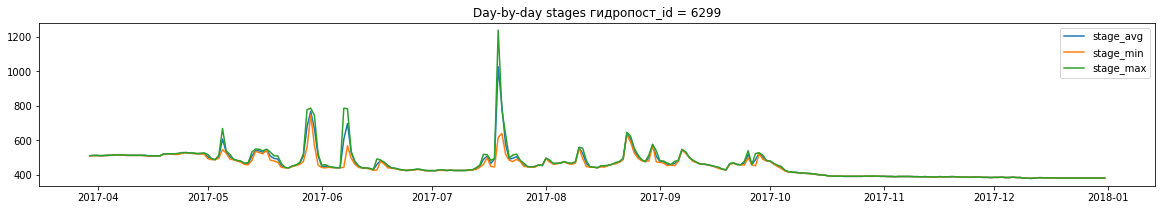

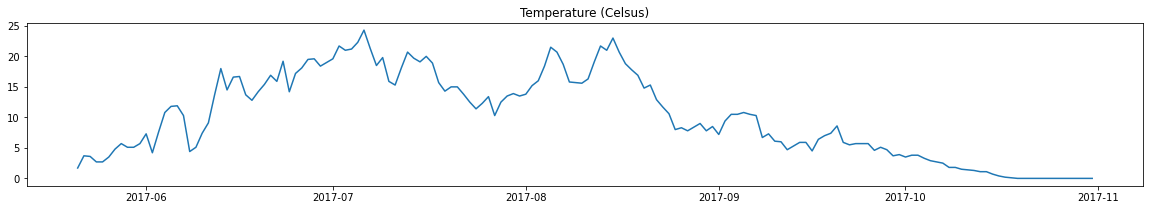

In [ ]:
date_start, date_end = '01-01-2017', '31-12-2017'
id = 6299

plt.figure(figsize = (20, 3))
sub_condition  = daily.date.between(date_start, date_end) & (daily.id == id)

stages = ['stage_avg', 'stage_min', 'stage_max']

plt.figure(figsize = (20, 3))
plt.title('Day-by-day stages гидропост_id = ' + str(id))
for stage in stages:
  plt.plot(daily[sub_condition][['date'] + [stage]].set_index('date'), label = stage)
  plt.legend()
plt.show()

plt.figure(figsize = (20,3))
plt.title('Temperature (Celsus)')
plt.plot(daily[sub_condition][['date', 'temp']].set_index('date'))
plt.show()

#  2.  Периодические значения (раз в 5 дней) высоты снега и толщины льда на гидропостах за период с 1984 по 2018 гг.

In [ ]:
%%time
files_ice = [f for f in files_hydro if '_ice' in f]
print(len(files_ice))
# Собираем в pandas dataframe 
ice = []
for filename in files_ice:
    tmp = pd.read_csv(path_to_hydro + filename, \
    encoding = 'cp1251', sep = ';', skiprows = 2, index_col = False, \
    names = ['date','ice_high','snow_high','place_code'])
    tmp['id'] = int(filename.replace('_ice.csv', ''))
    ice.append(tmp)
ice = pd.concat(ice)

181
CPU times: user 735 ms, sys: 27.9 ms, total: 763 ms
Wall time: 765 ms


In [ ]:
# Приводим к нужным типам

ice['date'] = pd.to_datetime(ice['date'], format='%d.%m.%Y')

ice['ice_high'] = ice['ice_high'].astype('str')
ice['ice_high'] = ice['ice_high'].map(lambda x: x.strip())
ice.loc[ice['ice_high'] == '', 'ice_high'] = np.nan
ice['ice_high'] = ice['ice_high'].astype('float64')

ice['snow_high'] = ice['snow_high'].astype('str')
ice['snow_high'] = ice['snow_high'].map(lambda x: x.strip())
ice.loc[ice['snow_high'] == '', 'snow_high'] = np.nan
ice['snow_high'] = ice['snow_high'].astype('float64')

ice['place_code'] = ice['place_code'].astype('int16')

In [ ]:
%%time
# Сортируем + переиндексируем:
ice.sort_values( ['id', 'date'], inplace = True)
ice.reset_index(drop=True, inplace=True)

CPU times: user 31 ms, sys: 4.87 ms, total: 35.9 ms
Wall time: 41.2 ms


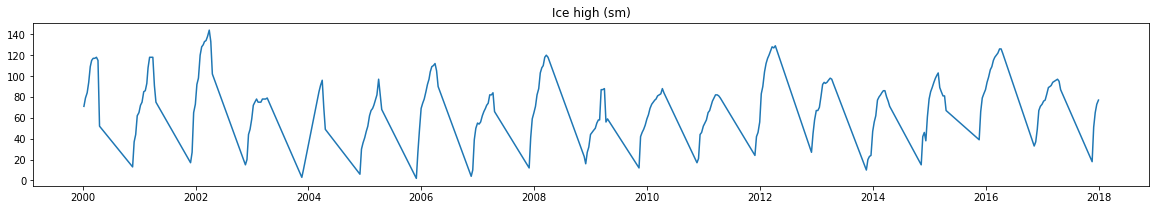

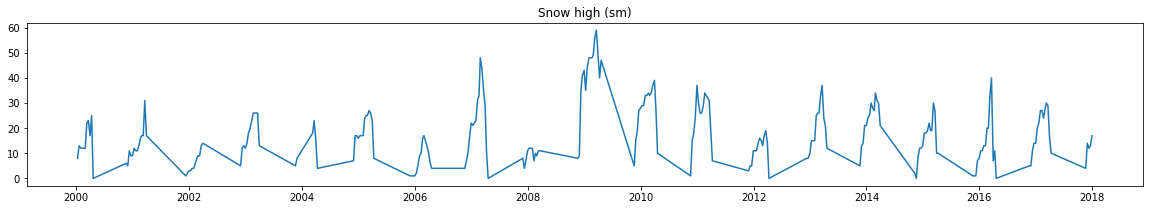

In [ ]:
date_start, date_end = '01-01-2000', '31-12-2020'
id = 6453
place_code = 13

sub_condition  = ice.date.between(date_start, date_end)&(ice.id == id)&(ice.place_code == 14)

plt.figure(figsize = (20,3))
plt.title('Ice high (sm)')
plt.plot(ice[sub_condition][['date', 'ice_high']].dropna().set_index('date'))
plt.show()

plt.figure(figsize = (20,3))
plt.title('Snow high (sm)')
plt.plot(ice[sub_condition][['date', 'snow_high']].dropna().set_index('date'))
plt.show()

# 3. Архив данных наблюдений на метеостанциях сети Росгидромета с 1985 по 2018

In [ ]:
# Получаем данные из папки
path_to_meteo = './datasets/meteo/'
files_meteo = ! ls -1 $path_to_meteo

In [ ]:
%%time
# Собираем в pandas dataframe 
meteo = []
for filename in files_meteo:
    tmp = pd.read_csv(path_to_meteo + filename, encoding = 'cp1251', sep = ';'  )
    tmp['id'] = int(filename.replace('.csv', ''))
    meteo.append(tmp)
meteo = pd.concat(meteo)

NameError: ignored

In [ ]:
meteo['date'] = pd.to_datetime(meteo['time'])
meteo.drop(columns = {'time'}, inplace = True)

In [ ]:
# Переиндексируем:

meteo.sort_values( ['station_id', 'date'], inplace = True)

meteo.reset_index(drop=True, inplace=True)

In [ ]:
meteo.info()

In [ ]:
date_start, date_end = '01-01-2013', '31-01-2013'
id = 4483421

plt.figure(figsize = (20, 3))
sub_condition  = meteo.date.between(date_start, date_end) & (meteo.id == id)

wind_speeds = ['wind_speed_avg', 'wind_speed_max']

plt.figure(figsize = (20, 5))
plt.title('Day-by-day wind_speed, station_id ' + str(id))
for wind_speed in wind_speeds:
  plt.plot(meteo[sub_condition][['date'] + [wind_speed]].set_index('date'), label = wind_speed)
  plt.legend()
plt.show()

In [ ]:
date_start, date_end = '01-01-2013', '31-01-2013'
id = 4483421

sub_condition  = meteo.date.between(date_start, date_end) & (meteo.id == id)
plt.figure(figsize = (20, 5))
plt.title('Humidity, station_name ' + str(id))
plt.plot(meteo[sub_condition][['date', 'humidity']].set_index('date'))
plt.show()

# 4. Данные наблюдений на метеостанциях за период с 01-01-1984 по 31-03-2020. Содержит меньшее количество станций (только сеть Всемирной Метеорологической Организации), но больше полей и охват.

In [ ]:
# Получаем данные из папки
path_to_meteo_new = './datasets/meteo_new/'
files_meteo_new = ! ls -1 $path_to_meteo_new

In [ ]:
# Убираем два лишних файла
files_meteo_new = files_meteo_new[:-2]

In [ ]:
%%time
# Собираем в pandas dataframe 
meteo_new = []
for filename in files_meteo_new:
    tmp = pd.read_csv(path_to_meteo_new + filename)
    tmp['id'] = int(filename.replace('.csv', ''))
    meteo_new.append(tmp)
meteo_new = pd.concat(meteo_new)

CPU times: user 14.6 s, sys: 827 ms, total: 15.5 s
Wall time: 15.9 s


In [ ]:
# Выбрасываем лишние колонки
meteo_new.drop(meteo_new.columns[0], axis=1, inplace=True)

In [ ]:
meteo_new.columns

Index(['stationNumber', 'year', 'month', 'day', 'time', 'localYear',
       'localMonth', 'localDay', 'localTimePeriod', 'timePeriodNum',
       'localTime', 'tz', 'startMeteoDay', 'horizontalVisibility',
       'horizontalVisibilityQuality', 'horizontalVisibilitySign',
       'cloudCoverTotal', 'cloudCoverTotalQuality', 'pastWeather',
       'pastWeatherQuality', 'presentWeather', 'presentWeatherQuality',
       'windDirection', 'windDirectionQuality', 'windSpeed',
       'windSpeedQuality', 'windSpeedSign', 'maximumWindGustSpeed',
       'maximumWindGustSpeedQuality', 'maximumWindGustSpeedSign',
       'totalAccumulatedPrecipitation', 'totalAccumulatedPrecipitationQuality',
       'soilTemperature', 'soilTemperatureQuality', 'groundMinimumTemperature',
       'groundMinimumTemperatureQuality', 'airTemperature',
       'airTemperatureQuality',
       'minimumTemperatureAtHeightAndOverPeriodSpecified',
       'minimumTemperatureAtHeightAndOverPeriodSpecifiedQuality',
       'maximumTem

In [ ]:
%%time
# Связываем колонки с временем и датой в одну колонку
meteo_new["date"] = pd.to_datetime(meteo_new["day"].astype(str) + "/" + \
                       meteo_new["month"].astype(str) + "/" + \
                       meteo_new["year"].astype(str) + " " + \
                       meteo_new["time"].astype(str) + ":00:00")

CPU times: user 5min 36s, sys: 987 ms, total: 5min 36s
Wall time: 5min 38s


In [ ]:
%%time
# Связываем колонки с локальным временем и датой в одну колонку
meteo_new["localDate"] = pd.to_datetime(meteo_new["localDay"].astype(str) + "/" + \
                            meteo_new["localMonth"].astype(str) + "/" + \
                            meteo_new["localYear"].astype(str) + " " + \
                            meteo_new["localTimePeriod"].astype(str) + ":00:00")

CPU times: user 5min 33s, sys: 1.02 s, total: 5min 34s
Wall time: 5min 37s


In [ ]:
# Выбрасываем теперь уже лишние колонки
meteo_new.drop(['day', 'localDay', 'month', 'localMonth', 'year', 'localYear', 'time', 'localTimePeriod'], axis='columns', inplace=True)

In [ ]:
meteo_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3580001 entries, 0 to 105188
Data columns (total 52 columns):
 #   Column                                                   Dtype         
---  ------                                                   -----         
 0   stationNumber                                            int64         
 1   timePeriodNum                                            int64         
 2   localTime                                                int64         
 3   tz                                                       int64         
 4   startMeteoDay                                            int64         
 5   horizontalVisibility                                     float64       
 6   horizontalVisibilityQuality                              int64         
 7   horizontalVisibilitySign                                 float64       
 8   cloudCoverTotal                                          float64       
 9   cloudCoverTotalQuality              

In [ ]:
# Переиндексируем:

meteo_new.sort_values( ['id', 'date'], inplace = True)

meteo_new.reset_index(drop=True, inplace=True)

In [ ]:
# В таблице очень много разряженных данных, уберем те колонки, где нулей больше 70 процентов
meteo_new = meteo_new.loc[:, (meteo_new==0).mean() < .7]

In [ ]:
# В таблице есть данные с пропусками, заполним их средним значением колонки
meteo_new = meteo_new.fillna(meteo_new.mean())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


<Figure size 1440x216 with 0 Axes>

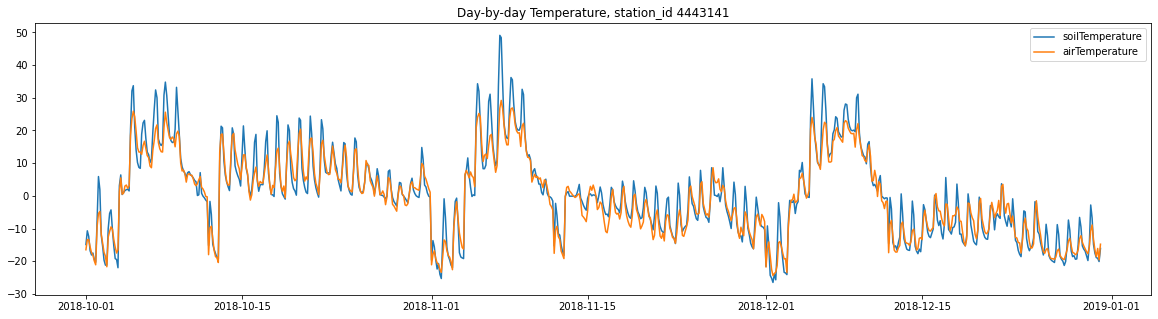

In [ ]:
date_start, date_end = '10-01-2018', '12-31-2018'
id = 4443141

plt.figure(figsize = (20, 3))
sub_condition  = meteo_new.date.between(date_start, date_end) & (meteo_new.id == id)

Temperatures = ['soilTemperature', 'airTemperature']

plt.figure(figsize = (20, 5))
plt.title('Day-by-day Temperature, station_id ' + str(id))
for Temperature in Temperatures:
  plt.plot(meteo_new[sub_condition][['date'] + [Temperature]].set_index('date'), label = Temperature)
  plt.legend()
plt.show()

# 5. Ежедневные значения уровня воды на гидрологический постах за период с 2018 по настоящее время.

In [ ]:
# Получаем данные из папки
path_to_hydro_2018_2020 = './datasets/hydro_2018-2020/'
files_hydro_2018_2020 = ! ls -1 $path_to_hydro_2018_2020

In [ ]:
%%time
# Собираем в pandas dataframe 
hydro_2018_2020 = []
for filename in files_hydro_2018_2020:
    tmp = pd.read_csv(path_to_hydro_2018_2020 + filename, sep = ';')
    hydro_2018_2020.append(tmp)
hydro_2018_2020 = pd.concat(hydro_2018_2020)

NameError: ignored

In [ ]:
# Переименовываем колонки
hydro_2018_2020.columns = ['date', 'level_water', 'id']

In [ ]:
# Удаляем из колонки Data ненужное значение времени

hydro_2018_2020['date'] = pd.to_datetime(hydro_2018_2020['date'])
hydro_2018_2020.info()

In [ ]:
%%time
# Сортируем + переиндексируем:
hydro_2018_2020.sort_values( ['id', 'date'], inplace = True)
hydro_2018_2020.reset_index(drop=True, inplace=True)

In [ ]:
# level_max = hydro_2018_2020.groupby(['Data'])['Level_water'].max()
# level_max.plot()

date_start, date_end = '01-01-2019', '31-12-2019'
id = 6299

plt.figure(figsize = (20, 3))
sub_condition  = hydro_2018_2020.date.between(date_start, date_end) & (hydro_2018_2020.id == id)

plt.title('Level_water (cm) гидропост_id = '+ str(id))
plt.plot(hydro_2018_2020[sub_condition][['date', 'level_water']].set_index('date'))
plt.show()

# Выгружаем готовые фреймы в pkl

In [ ]:
%%time
# Выгружаем готовые фреймы в pkl:

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name
df_list = [daily, ice, meteo_new , meteo, hydro_2018_2020 ]
for df_ in df_list:
  print (df_.info())
  df_.to_pickle(get_df_name(df_)+'.pkl')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201371 entries, 0 to 2201370
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   stage_avg   float16       
 2   stage_min   float16       
 3   stage_max   float16       
 4   temp        float64       
 5   water_code  object        
 6   id          int64         
dtypes: datetime64[ns](1), float16(3), float64(1), int64(1), object(1)
memory usage: 79.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128389 entries, 0 to 128388
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        128389 non-null  datetime64[ns]
 1   ice_high    76688 non-null   float64       
 2   snow_high   67951 non-null   float64       
 3   place_code  128389 non-null  int16         
 4   id          128389 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int16(1),

In [ ]:
!ls -l --block-size=M

total 2580M
-rw-r--r-- 1 root root   74M Oct 23 20:00 daily.pkl
drwxr-xr-x 8 root root    1M Oct 13 05:07 datasets
-rw-r--r-- 1 root root   54M Oct 23 20:00 hydro_2018_2020.pkl
-rw-r--r-- 1 root root    5M Oct 23 20:00 ice.pkl
-rw-r--r-- 1 root root  820M Oct 23 20:00 meteo_new.pkl
-rw-r--r-- 1 root root 1630M Oct 23 20:00 meteo.pkl
drwxr-xr-x 1 root root    1M Oct 14 16:31 sample_data


# Описание подготовленных Dataframes

## 1. Датафрейм daily

Содержат ежедневные значения уровня воды и температуры воды на гидрологический постах за период с 1984 по 2018 гг.

Cобран из 198 csv-файлов

date - дата измерений

stage_avg - средний уровень воды за день (см.)

stage_min - минимальный уровень воды за день (см.)

stage_max – максимальный уровень воды за день (см.)

temp - средняя температура воды за день (°C)

water_code - код состояния водного объекта

id - номер гидрологического поста

## 2. Датафрейм ice
Содержит периодические значения (раз в 5 дней) высоты снега и толщины льда на гидрологических постах за период с 1984 по 2018 гг.

Cобран из 181 csv-файлов

date datetime64[ns] - дата измерения

ice_high Толщина льда (см)

snow_high Высота снега (см)

place_code Место измер - код места ледовых измерений

id - номер гидрологического поста

## 3. Датафрейм meteo  
Cобран из 108 файлов meteo/NNNNNNN.csv, где NNNNNNN номер синтаптической станции. Cодержит архив наблюдений на метеостанциях сети Росгидромета с 1985 по 2018, всего 108 станций  

station_name Название станции 

station_id Идентификатор станции   

visibility_distance Горизонтальная дальность видимости  

visibility_distance_quality Признак качества  

wind_direction Направление ветра  

wind_direction_quality Признак качества  

wind_speed_avg Средняя скорость ветра  

wind_speed_avg_quality Признак качества  

wind_speed_sign Признак наличия знака >  

wind_speed_max Максимальное скорость ветра  

wind_speed_max_quality Признак качества  

wind_speed_max_sign Признак наличия знака >  

precipitation_amount Сумма осадков за период между сроками  

precipitation_amount_quality Признак качества  

temperature_ground Температура поверхности почвы в срок  

temperature_ground_quality Признак качества  

temperature_air Температура воздуха в срок по сухому терм-ру  

temperature_air_quality Признак качества  

humidity Относительная влажность воздуха в срок  

humidity_quality Признак качества  

date Срок наблюдения  

id Номер метеостанции
 

## 4. Датафрейм meteo_new
Содержит данные наблюдений на метеостанциях за период с 01-01-1984 по 31-03-2020. Количество станций меньше (только те, что входят сеть Всемирной Метеорологической Организации), чем в прошлом, но больше полей и охват
Cобран из 34 csv-файлов

date формат - year-month-day hour:minutes:seconds год месяц день срок по Гринвичу

localDate - формат year-month-day hour:minutes:seconds год месяц день срок источника (местный)

stationNumber - Синоптический индекс станции Всемирной Метеорологической организации

timePeriodNum - Номер срока в сутках по поясному декретному зимнему времени (ПДЗВ)

localTime - Время местное

tz Номер - часового пояса

startMeteoDay - Начало метеорологических суток по ПДЗВ

horizontalVisibility - Горизонтальная видимость

horizontalVisibilityQuality - Признак качества

cloudCoverTotal - Общее количество облачности

pastWeather - Погода между сроками

presentWeather - Погода в срок наблюдения

windDirection - Направление ветра

windSpeed - Средняя скорость ветра

maximumWindGustSpeed - Максимальная скорость ветра

totalAccumulatedPrecipitationQuality - Признак качества

soilTemperature - Температура поверхности почвы

groundMinimumTemperature - Минимальная температура поверхности почвы

airTemperature - Температура воздуха по сухому термометру

minimumTemperatureAtHeightAndOverPeriodSpecified - Минимальная температура 
воздуха между сроками

maximumTemperatureOverPeriodSpecified - Максимальная температура воздуха между сроками

relativeHumidity - Относительная влажность воздуха

vapourPressure - Дефицит насыщения водяного пара

dewpointTemperature - Температура точки росы

pressure Атмосферное - давление на уровне станции

pressureReducedToMeanSeaLevel - Атмосферное давление на уровне моря

characteristicOfPressureTendency - Характеристика барической тенденции

HourPressureChange3 - Величина барической тенденции

id - Номер метеостанции

## 5. Датафрейм hydro_2018_2020  
Cобран из 1 файла Содержит ежедневные значения уровня воды на гидрологический постах за период с 2018 по настоящее время.

date дата замера

level_water максимальный уровень за день

id номер гидрологического поста